https://www.kaggle.com/datasets/meirnizri/covid19-dataset

In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.



In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate

In [2]:
df = pd.read_csv('Covid Data.csv')

content
The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

* sex: 1 for female and 2 for male.
* age: of the patient.
* classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
* degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
* patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
* pneumonia: whether the patient already have air sacs inflammation or not.
* pregnancy: whether the patient is pregnant or not.
* diabetes: whether the patient has diabetes or not.
* copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
* asthma: whether the patient has asthma or not.
* inmsupr: whether the patient is immunosuppressed or not.
* hypertension: whether the patient has hypertension or not.
* cardiovascular: whether the patient has heart or blood vessels related disease.
* renal chronic: whether the patient has chronic renal disease or not.
* other disease: whether the patient has other disease or not.
* obesity: whether the patient is obese or not.
* tobacco: whether the patient is a tobacco user.
* usmr: Indicates whether the patient treated medical units of the first, second or third level.
* medical unit: type of institution of the National Health System that provided the care.
* intubed: whether the patient was connected to the ventilator.
* icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
* date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

## EDA

In [3]:
df

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [5]:
# create a boolean target column
df['DIED'] = [0 if i == '9999-99-99' else 1 for i in df.DATE_DIED]
df.drop(columns=['DATE_DIED'], inplace=True)

In [6]:
discrete_cols = df.drop(axis=1, columns=['AGE', 'DIED']).columns.values

Plot the columns to see which columns have effect to the target column

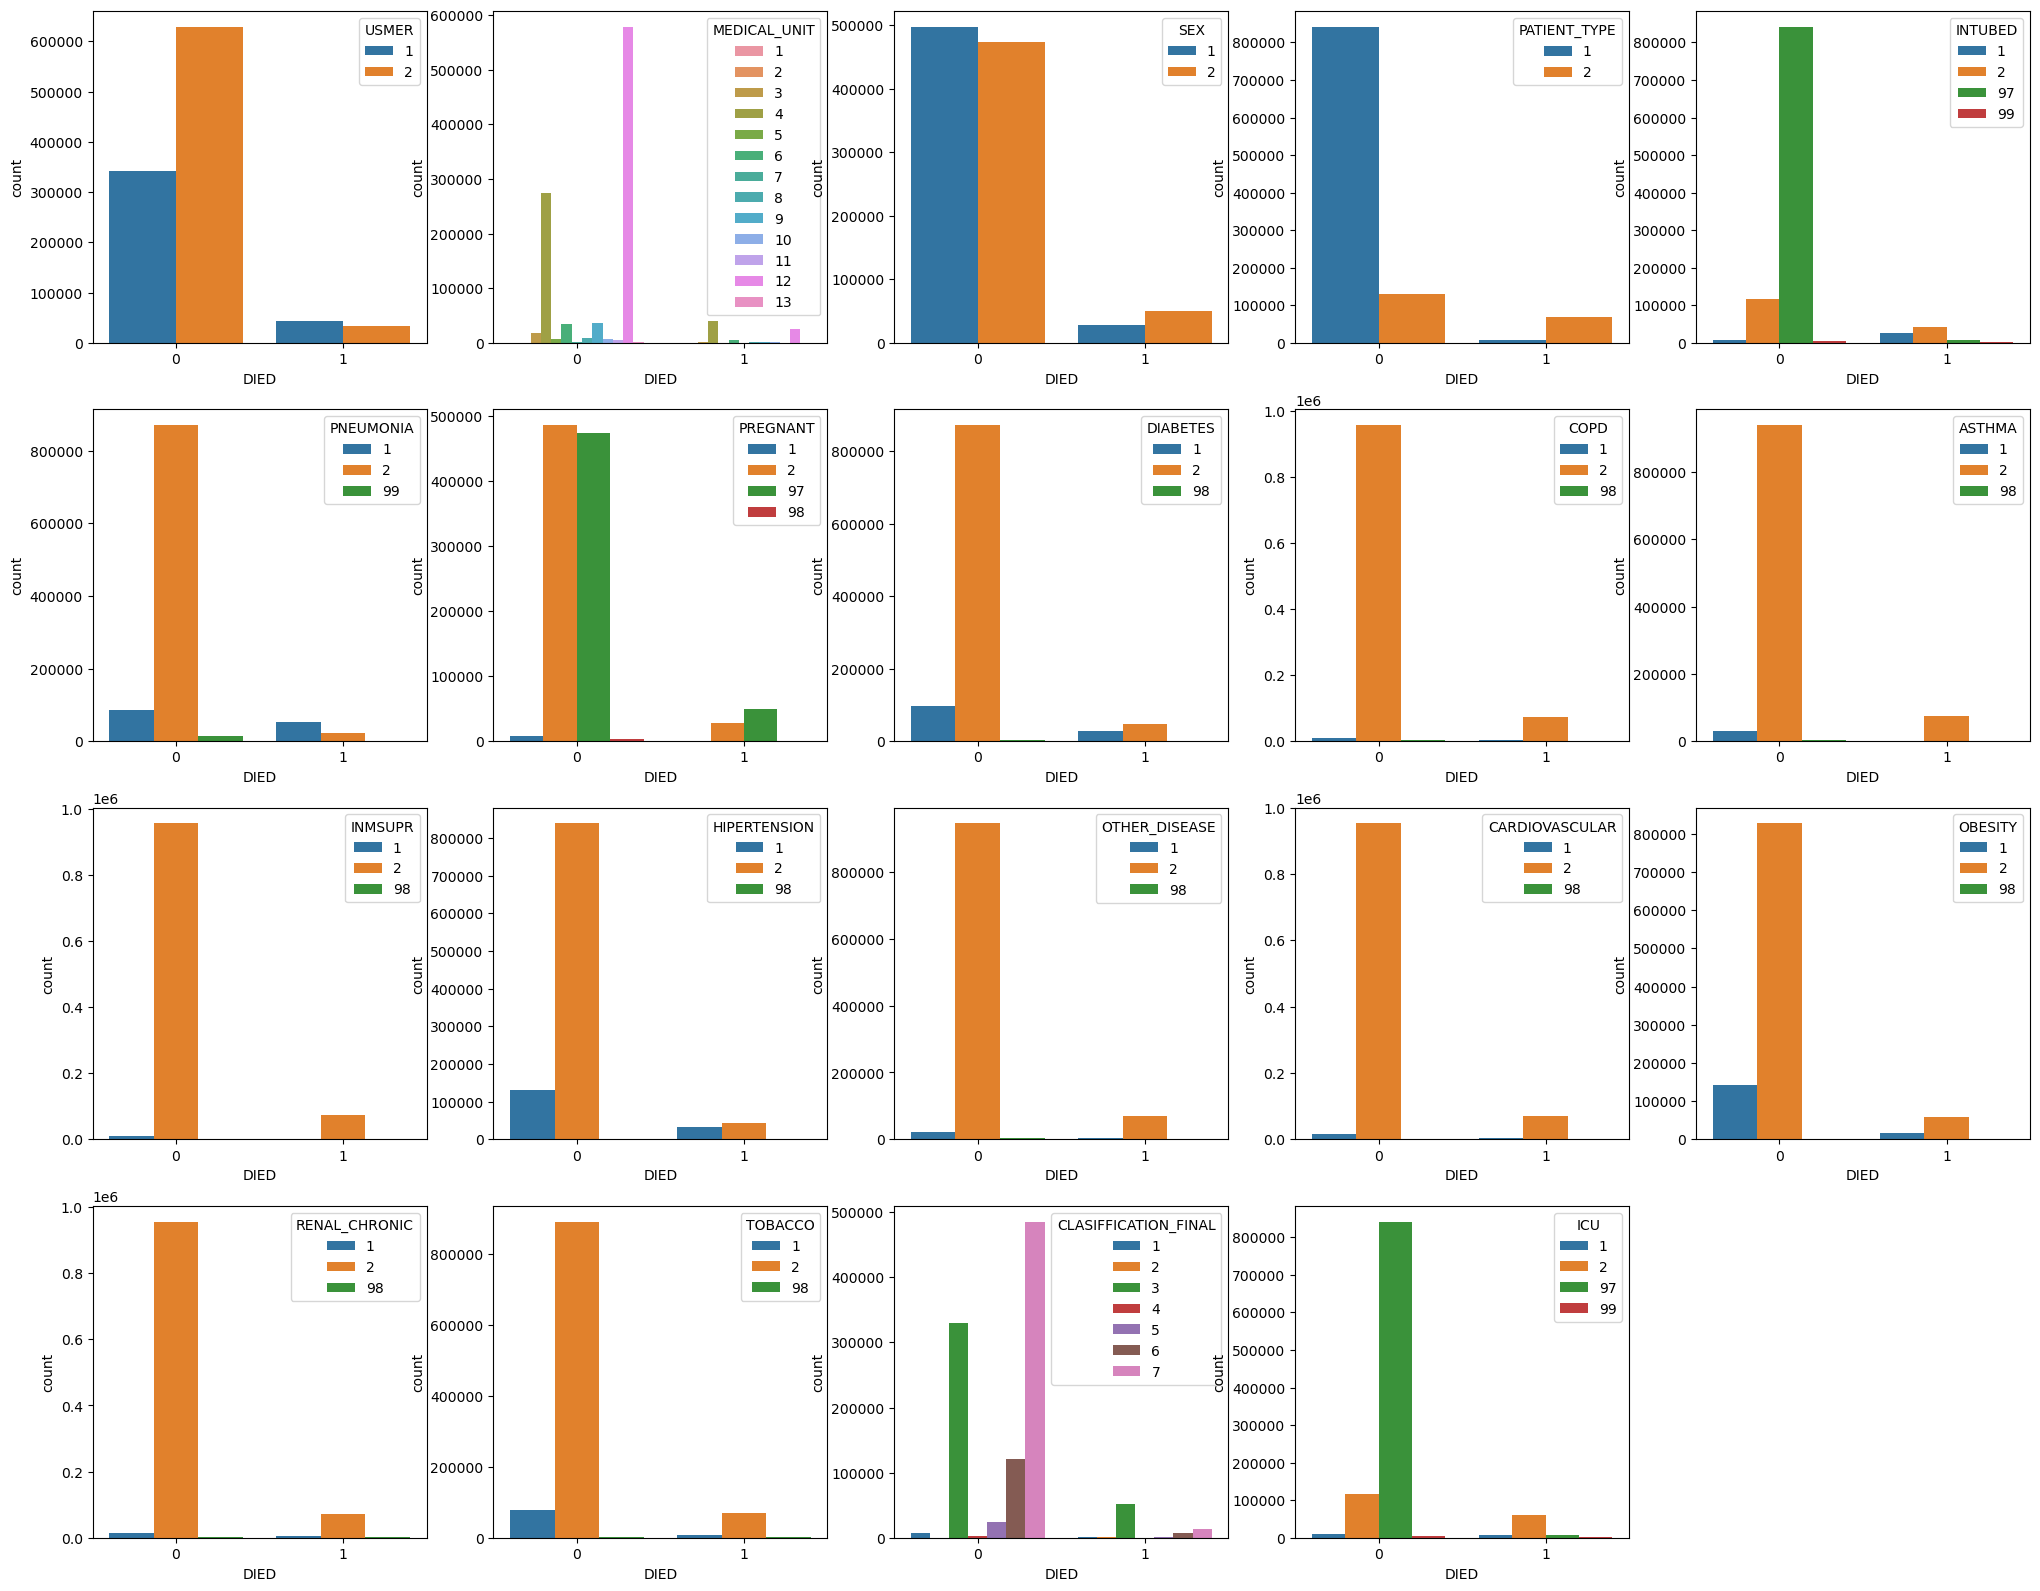

In [7]:
fig = plt.figure(figsize=(25,25))
n = 1
for column in discrete_cols:
    ax = plt.subplot(5,5,n)
    sns.countplot(x='DIED', hue=column, data=df)
    n += 1
plt.show()

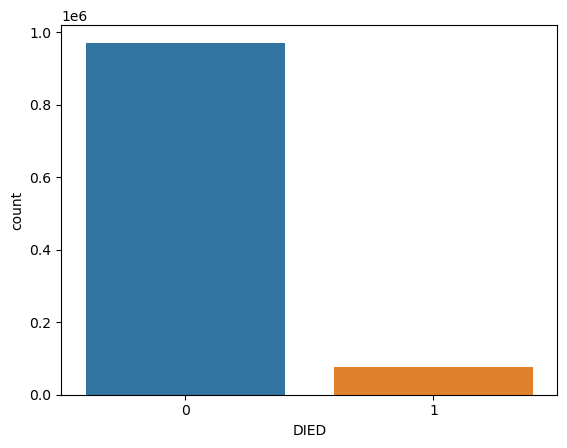

In [8]:
sns.countplot(x='DIED',data=df);

Target column is imbalanced. I will use RandomUnderSampler to make balance on the training data.

In [9]:
# create one value from two missing values 97 & 99 except AGE
for c in df.columns:
    if c != 'AGE':
        df.loc[(df[c] == 97) | (df[c] == 98), c] = 99

In [10]:
# check how many missing values the attributes have
for c in df.columns:
    q = len(df.loc[df[c] == 99])
    if q != 0:
        print(f"{c} - {q} - {q / len(df)}")

INTUBED - 855869 - 0.816221061917364
PNEUMONIA - 16003 - 0.015261664640106812
AGE - 86 - 8.201606942755645e-05
PREGNANT - 527265 - 0.5028395679851226
DIABETES - 3338 - 0.0031833679040602723
COPD - 3003 - 0.002863886703383163
ASTHMA - 2979 - 0.002840998497961519
INMSUPR - 3404 - 0.0032463104689697923
HIPERTENSION - 3104 - 0.0029602079011992466
OTHER_DISEASE - 5045 - 0.0048112915146746775
CARDIOVASCULAR - 3076 - 0.0029335049948739957
OBESITY - 3032 - 0.0028915432849343156
RENAL_CHRONIC - 3006 - 0.0028667477290608683
TOBACCO - 3220 - 0.0030708342274038576
ICU - 856032 - 0.8163765109791861


#### Train Logistic Regression to take relevant features

In [11]:
X = df.drop(columns='DIED', axis=1)
y = df['DIED']

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [14]:
param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model = LogisticRegression(penalty='l1', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(X_std, y)

/Users/siarheiyahela/Desktop/projects/my_projects/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/siarheiyahela/Desktop/projects/my_projects/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/siarheiyahela/Desktop/projects/my_projects/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/siarheiyahela/Desktop/projects/my_projects/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [12]:
bp = {'C': 10}
model = LogisticRegression(**bp, penalty='l1', solver='liblinear')
model.fit(X,y)

LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [13]:
log_features_eval = pd.DataFrame({'X': X.columns, 'coefs':model.coef_[0]}).sort_values(by='coefs')
log_features_eval

,X,coefs
18,CLASIFFICATION_FINAL,-0.265028
0,USMER,-0.200903
1,MEDICAL_UNIT,-0.055021
5,PNEUMONIA,-0.018226
4,INTUBED,-0.017720
12,HIPERTENSION,-0.004727
16,RENAL_CHRONIC,-0.003899
8,DIABETES,-0.003328
11,INMSUPR,-0.003080
13,OTHER_DISEASE,0.001502


In [14]:
log_features = log_features_eval.loc[(log_features_eval.coefs > 0.01) | (log_features_eval.coefs < -0.01)].X.values

In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in split.split(X,y):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]

### Train baseline model

- SGDClassifier
- RandomForestClassifier

In [16]:
estimators = {'SGDClassifier': SGDClassifier(),
              'RFC': RandomForestClassifier()}


for name,estimator in estimators.items():
    estimator = estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    print(f"{name}:{recall_score(y_test, y_pred, average='micro')}")


SGDClassifier:0.9052380611782658
RFC:0.9440812531292468


#### Random Forest Classifier

#### Solve the imbalanced data problem with Undersampling
it is most important to have a large recall because it is more important to identify the patient who is at risk

In [17]:
y.value_counts()

0    971633
1     76942
Name: DIED, dtype: int64

In [18]:
under = RandomUnderSampler(sampling_strategy=1) 
X_resample, y_resample = under.fit_resample(X_train[log_features], y_train)

In [19]:
rfc =  RandomForestClassifier()
rfc.fit(X_resample, y_resample)
y_pred = rfc.predict(X_test[log_features])

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    194327
           1       0.38      0.93      0.54     15388

    accuracy                           0.88    209715
   macro avg       0.69      0.91      0.74    209715
weighted avg       0.95      0.88      0.91    209715



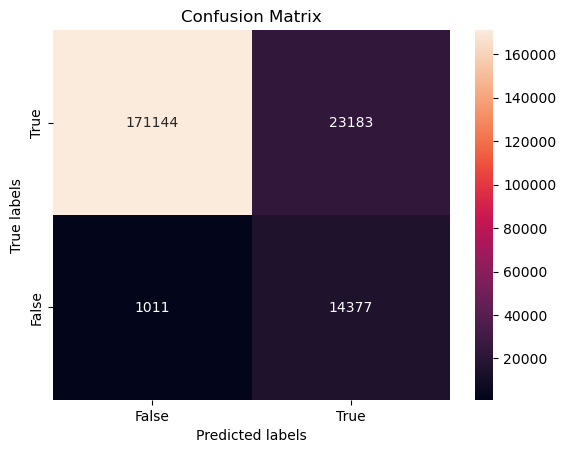

In [21]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['False', 'True']); ax.yaxis.set_ticklabels(['True', 'False']);

#### Maximaze Recall with SGDClassifier

In [31]:
scaler = StandardScaler()
X_std_train = scaler.fit_transform(X_resample)
X_std_test = scaler.fit_transform(X_test[log_features])

clf = SGDClassifier(loss="log_loss", penalty="l2", max_iter=100)
clf.fit(X_std_train, y_resample)
y_pred = clf.predict(X_std_test)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86    194327
           1       0.24      0.98      0.38     15388

    accuracy                           0.77    209715
   macro avg       0.62      0.86      0.62    209715
weighted avg       0.94      0.77      0.82    209715



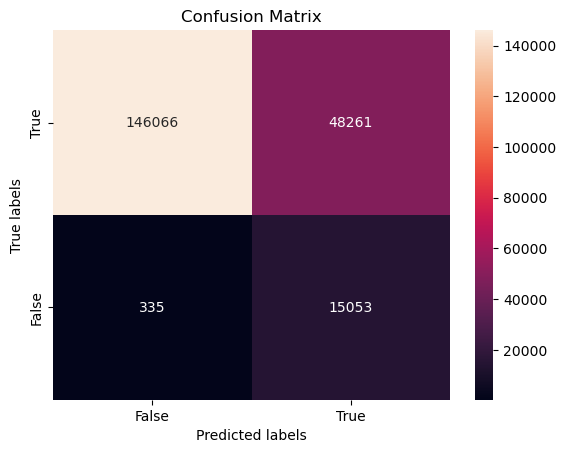

In [33]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['False', 'True']); ax.yaxis.set_ticklabels(['True', 'False']);

#### Cross validation

In [39]:
under = RandomUnderSampler(sampling_strategy=1) 
X_all_resample, y_all_resample = under.fit_resample(X[log_features], y)

In [45]:
scores = cross_validate(clf, X_all_resample, y_all_resample, cv=3,
                       scoring=['precision', 'recall', 'f1'],
                        return_train_score=True)

In [46]:
scores

{'fit_time': array([1.55829191, 1.48758078, 1.60931611]),
 'score_time': array([0.03891206, 0.03812099, 0.036057  ]),
 'test_precision': array([0.89388047, 0.90270863, 0.65507572]),
 'train_precision': array([0.89196758, 0.90546658, 0.92691123]),
 'test_recall': array([0.87823137, 0.83421709, 0.13662417]),
 'train_recall': array([0.88174286, 0.82666589, 0.89796276]),
 'test_f1': array([0.88598682, 0.86711246, 0.22609369]),
 'train_f1': array([0.88682575, 0.86427378, 0.91220739])}